# ProjectUtility: Semi Random Collection of Core functions

> utility functions



In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import numpy as np
import re

In [ ]:
#| export
def convert_palette_to_hex(palette_name, n_colors):
    """
    Convert a named color palette to hex color codes.
    
    Parameters:
    -----------
    palette_name : str
        Name of the palette (e.g., 'tab10', 'Set1', 'husl', 'viridis')
    n_colors : int
        Number of colors to generate
        
    Returns:
    --------
    list
        List of hex color codes
    """

    
    try:
        # Try to get palette from seaborn
        palette = sns.color_palette(palette_name, n_colors)
        hex_colors = [mcolors.rgb2hex(color) for color in palette]
        return hex_colors
    except:
        try:
            # Try as a matplotlib colormap
            cmap = plt.cm.get_cmap(palette_name, n_colors)
            hex_colors = [mcolors.rgb2hex(cmap(i)) for i in range(n_colors)]
            return hex_colors
        except:
            # Fallback to default
            print(f"Palette '{palette_name}' not found, using default.")
            return sns.color_palette("husl", n_colors).as_hex()


In [ ]:
#| export
def create_group_color_mapping(items, group_size=3, palette=None, palette_name=None, return_color_to_group=False):
    """
    Create a color mapping dictionary that assigns the same color to items in groups.
    
    Parameters:
    -----------
    items : list
        List of items to be mapped to colors
    group_size : int
        Number of items to assign to each color (default: 3)
    palette : list or None
        List of colors to use. If None, uses default colors in hex format.
    palette_name : str or None
        Name of a seaborn/matplotlib palette (e.g., 'tab10', 'Set1') to use.
        This is used if palette is None.
    return_color_to_group : bool
        If True, also returns a dictionary mapping colors to group names
        
    Returns:
    --------
    dict or tuple
        Dictionary mapping each item to its assigned color (hex format)
        If return_color_to_group is True, also returns a dict mapping colors to group names
    """
    # Calculate how many colors we need
    num_groups = (len(items) + group_size - 1) // group_size  # Ceiling division
    
    # Generate or use provided color palette in hex format
    if palette is None:
        if palette_name is not None:
            # Use the specified palette name
            colors = convert_palette_to_hex(palette_name, num_groups)
        else:
            # Default hex color palette
            default_colors = [
                '#FF5733', '#33FF57', '#3357FF', '#FF33A8', '#33FFF5', 
                '#FFD133', '#A833FF', '#FF8D33', '#33ACFF', '#FF3352'
            ]
            
            # If we need more colors, generate them
            if num_groups > len(default_colors):
                
                
                # Use seaborn to generate additional colors in hex
                additional_colors = sns.color_palette("husl", num_groups - len(default_colors)).as_hex()
                colors = default_colors + additional_colors
            else:
                colors = default_colors[:num_groups]
    else:
        # Convert any non-hex colors in provided palette to hex format
        
        colors = []
        for color in palette:
            if isinstance(color, str) and color.startswith('#'):
                colors.append(color)
            else:
                try:
                    colors.append(mcolors.to_hex(color))
                except:
                    colors.append('#888888')  # Default gray if conversion fails
        
        # If palette is too small, cycle it
        if len(colors) < num_groups:
            colors = colors * (num_groups // len(colors) + 1)
        
        colors = colors[:num_groups]
    
    # Create the mapping dictionary
    color_mapping = {}
    # If requested, also create a mapping from color to group name
    color_to_group = {}
    
    for i, item in enumerate(items):
        group_idx = i // group_size
        group_name = f"Group {group_idx + 1}"
        color_idx = min(group_idx, len(colors) - 1)  # Ensure we don't go out of bounds
        color = colors[color_idx]
        
        color_mapping[item] = color
        
        # Add to color_to_group dictionary if it doesn't exist yet
        if return_color_to_group and color not in color_to_group:
            color_to_group[color] = group_name
    
    if return_color_to_group:
        return color_mapping, color_to_group
    else:
        return color_mapping



In [ ]:

# Example usage with different palette options
def demonstrate_group_mapping_palettes():
    # Create a list of items
    items = [f'gene_{i}' for i in range(15)]
    
    # Create a figure with multiple palette examples
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 10))
    
    # Example 1: Default palette
    color_map1, group_map1 = create_group_color_mapping(
        items, group_size=3, return_color_to_group=True
    )
    
    # Example 2: tab10 palette
    color_map2, group_map2 = create_group_color_mapping(
        items, group_size=3, palette_name='tab10', return_color_to_group=True
    )
    
    # Example 3: Set2 palette
    color_map3, group_map3 = create_group_color_mapping(
        items, group_size=3, palette_name='Set2', return_color_to_group=True
    )
    
    # Example 4: viridis palette
    color_map4, group_map4 = create_group_color_mapping(
        items, group_size=3, palette_name='viridis', return_color_to_group=True
    )
    
    # Plot all examples
    palettes = [
        ('Default Palette', color_map1, group_map1),
        ('tab10 Palette', color_map2, group_map2),
        ('Set2 Palette', color_map3, group_map3),
        ('viridis Palette', color_map4, group_map4)
    ]
    
    for i, (title, color_map, group_map) in enumerate(palettes):
        ax = axes[i]
        
        # Plot bars
        for j, item in enumerate(items):
            ax.barh(0, 0.8, left=j, height=0.8, color=color_map[item], alpha=0.7)
            if i == 0:  # Only add labels on the first plot
                ax.text(j+0.4, 0, item, rotation=90, ha='center', va='bottom')
        
        # Add legend
        
        legend_elements = [Patch(facecolor=color, label=group) for color, group in group_map.items()]
        ax.legend(handles=legend_elements, loc='upper center', ncol=len(group_map))
        
        ax.set_ylim(-0.5, 0.5)
        ax.set_xlim(-0.5, len(items) - 0.5)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title(title)
    
    plt.tight_layout()
    
    # Print example of hex colors from tab10
    print("Example hex colors from tab10 palette:")
    for color in list(group_map2.keys())[:5]:
        print(color)
    
    return fig, axes

Example hex colors from tab10 palette:
#1f77b4
#ff7f0e
#2ca02c
#d62728
#9467bd


(<Figure size 864x720 with 4 Axes>,
 array([<AxesSubplot:title={'center':'Default Palette'}>,
        <AxesSubplot:title={'center':'tab10 Palette'}>,
        <AxesSubplot:title={'center':'Set2 Palette'}>,
        <AxesSubplot:title={'center':'viridis Palette'}>], dtype=object))

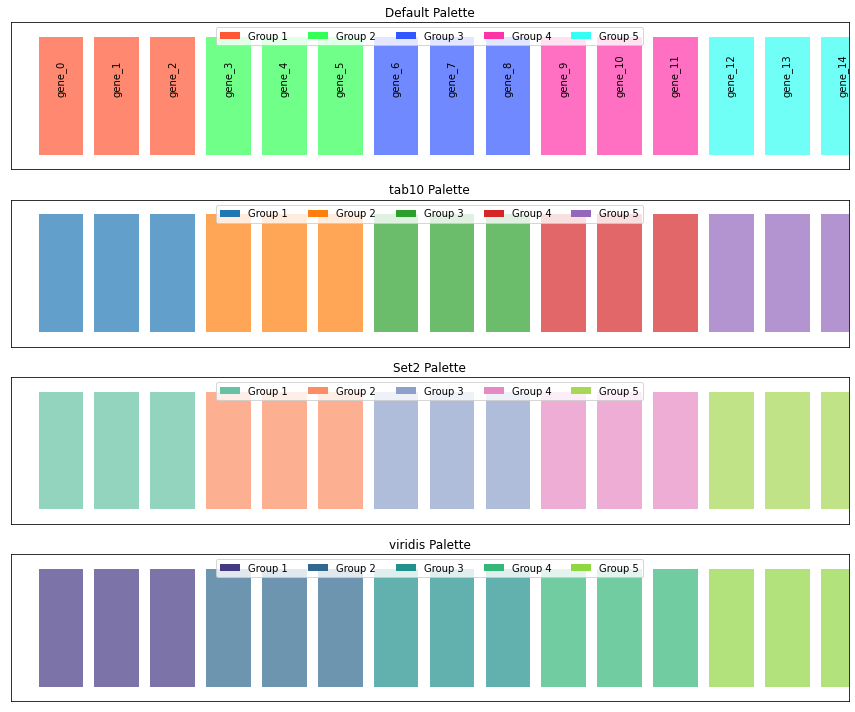

In [ ]:
demonstrate_group_mapping_palettes()

In [ ]:
#| export
def norm_loading(df):
    '''
    normalization loading for the columns of a dataframe
    the columns shuld be comparable (ie do not mix fractionated samples,
    for example cytosolic and extracellulars)
    '''
    medians = df.median(axis=0)
    print('medians',np.array(medians))
    target = np.mean(medians)
    print('target', target)
    norm_facs = target / medians
    print('norm_facs', np.array(norm_facs))
    data_norm = df.multiply(norm_facs, axis=1)
    return data_norm

def quantileNormalize(df_input, keep_na=True):
    df = df_input.copy()
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        norm = [rank[i] for i in t]
        if keep_na == True:
            norm = [np.nan if np.isnan(a) else b for a,b in zip(df[col],norm)]
        df[col] =  norm             
    return df

def norm_loading_TMT(df):
    #normalization of dataframe
    #to account for uneven loading
    #only for TMT datasets
    col_sum = df.sum(axis=0)
    #print(col_sum)
    target = np.mean(col_sum)
    #print(target)
    norm_facs = target / col_sum
    #print(norm_facs)
    data_norm = df.multiply(norm_facs, axis=1)
    return  data_norm

In [ ]:
#| export
def ires_norm(df, exps_columns):
    '''
    implement IRES norm for TMT
    example
    irs_df = ires_norm(df.replace(0,np.nan).fillna(df.mean()),[tmt10, tmt6])
    remember to set nan again after norm
    irs_df[df.replace(0,np.nan).isna()]=np.nan
    '''
    
    # Ensure the DataFrame contains the required columns
    if not all(col in df for cols in exps_columns for col in cols):
        raise ValueError("DataFrame does not contain all the required columns")
    
    
    df_list = [df[exp_cols] for exp_cols in exps_columns]

    # Sum by row for each experiment and concatenate results
    df_sums = pd.concat([exp.sum(axis=1, skipna=True) for exp in df_list], axis=1)
    df_sums.columns = [f'exp_{n+1}' for n in range(len(exps_columns))]

    # Compute geometric mean of sums
    # Add a small constant for numerical stability
    df_sums["gmean"] = np.exp(np.nanmean(np.log(df_sums+1e-8), axis=1))  

    # Compute and apply scaling factors
    for n, _ in enumerate(exps_columns):
        scaling_col = f'exp_{n+1}_scaling'
        df_sums[scaling_col] = df_sums["gmean"] / df_sums[f'exp_{n+1}']
        df_list[n] = df_list[n].multiply(df_sums[scaling_col].values, axis=0)

    final_df = pd.concat(df_list, axis=1)


    
    final_df = norm_loading_TMT(final_df)

    return final_df

In [ ]:
#| export
#get only the gene id from
#the new TryTripDB format
def clean_id(temp_id):
    temp_id = temp_id.split(':')[0]
    if temp_id.count('.')>2:
        temp_id = '.'.join(temp_id.split('.')[0:3])
    return temp_id

In [ ]:
#| export
#format legend of hist plots 
#with lines instead of boxes
def hist_legend(ax, title = False):
    handles, labels = ax.get_legend_handles_labels()
    new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
    ax.legend(handles=new_handles, labels=labels, 
    title=title,loc='center left', bbox_to_anchor=(1, 0.5))  

In [ ]:
#| export
def parse_fasta_file(fasta_file):
    '''
    create a dictionary of protein id to gene product
    using fasta file from tritrypDB
    '''
    protein_dict = {}
    current_protein_id = None

    with open(fasta_file, 'r') as f:
        for line in f:
            if line.startswith('>'):
                protein_id = '.'.join(line.split('>')[1].split('.')[0:-3]).split(':')[0]
                gene_product_match = re.search(r'gene_product=([^|]+)', line)

                if  gene_product_match:
                    #protein_id = protein_id_match.group(1)
                    gene_product = gene_product_match.group(1)
                    protein_dict[protein_id] = gene_product.strip()
                    current_protein_id = protein_id
                else:
                    current_protein_id = None
    return protein_dict

def add_desc(data, prot_to_desc):
    desc = []
    for item in data.index.values:
        item_desc = []
        for prot in item.split(';'):
            clean_prot = prot.split(':')[0]
            item_desc.append(prot_to_desc.get(clean_prot,clean_prot))
        item_desc = ';'.join(item_desc)
        desc.append(item_desc)                        
    return desc

In [ ]:
#| export
from sklearn.preprocessing import StandardScaler

def get_scaled_df(df):
    scaler = StandardScaler()
    tmp_df = np.log10(df).dropna().copy()
    tmp_df.index = [n .split(':') [0] for n in tmp_df.index.values]
    tmp_df = pd.DataFrame(scaler.fit_transform(tmp_df),
                          index=tmp_df.index,columns=tmp_df.columns)
    return tmp_df


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()